# executorlib

## Define workflow with executorlib

In [1]:
import numpy as np
from executorlib import SingleNodeExecutor, get_item_from_future

In [2]:
from workflow import calculate_qe, generate_structures, get_bulk_structure, plot_energy_volume_curve

In [3]:
workflow_json_filename = "executorlib_qe.json"

In [4]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [5]:
with SingleNodeExecutor(export_workflow_filename=workflow_json_filename) as exe:
    structure_future = exe.submit(
        get_bulk_structure,
        element="Al",
        a=4.04,
        cubic=True,
    )
    calc_mini_future = exe.submit(
        calculate_qe,
        working_directory="mini",
        input_dict={
            "structure": structure_future,
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "vc-relax",
            "smearing": 0.02,
        },
    )
    number_of_strains = 5
    structure_lst_future = exe.submit(
        generate_structures,
        structure=get_item_from_future(calc_mini_future, key="structure"),
        strain_lst=np.linspace(0.9, 1.1, number_of_strains),
    )
    calc_future_lst = []
    for i, structure_strain in [[i, get_item_from_future(structure_lst_future, key="s_" + str(i))] for i in range(number_of_strains)]:
        calc_future_lst.append(exe.submit(
            calculate_qe,
            working_directory="strain_" + str(i),
            input_dict={
                "structure": structure_strain,
                "pseudopotentials": pseudopotentials,
                "kpts": (3, 3, 3),
                "calculation": "scf",
                "smearing": 0.02,
            },
        ))
    plot_future = exe.submit(
        plot_energy_volume_curve,
        volume_lst=[get_item_from_future(future=f, key="volume") for f in calc_future_lst],
        energy_lst=[get_item_from_future(future=f, key="energy") for f in calc_future_lst],
    )

In [6]:
!cat {workflow_json_filename}

{
    "version": "0.1.0",
    "nodes": [
        {
            "id": 0,
            "type": "function",
            "value": "workflow.get_bulk_structure"
        },
        {
            "id": 1,
            "type": "function",
            "value": "workflow.calculate_qe"
        },
        {
            "id": 2,
            "type": "function",
            "value": "workflow.generate_structures"
        },
        {
            "id": 3,
            "type": "function",
            "value": "workflow.calculate_qe"
        },
        {
            "id": 4,
            "type": "function",
            "value": "workflow.calculate_qe"
        },
        {
            "id": 5,
            "type": "function",
            "value": "workflow.calculate_qe"
        },
        {
            "id": 6,
            "type": "function",
            "value": "workflow.calculate_qe"
        },
        {
            "id": 7,
            "type": "function",
            "value": "workflow.calculate_qe"
     

## Load Workflow with aiida

In [7]:
from aiida import orm, load_profile

load_profile()

Profile<uuid='c08748df7ab74ec08c14e5f16cebc987' name='pwd'>

In [8]:
from python_workflow_definition.aiida import load_workflow_json

In [9]:
wg = load_workflow_json(file_name=workflow_json_filename)

In [10]:
wg.nodes.get_bulk_structure.inputs.a.value = orm.Float(4.05)

01/16/2026 08:27:06 AM <71653> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [1663|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure
01/16/2026 08:27:06 AM <71653> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [1663|WorkGraphEngine|update_task_state]: Task: get_bulk_structure, type: PYFUNCTION, finished.
01/16/2026 08:27:06 AM <71653> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [1663|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict
01/16/2026 08:27:07 AM <71653> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [1663|WorkGraphEngine|update_task_state]: Task: get_dict, type: PYFUNCTION, finished.
01/16/2026 08:27:07 AM <71653> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [1663|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe
01/16/2026 08:28:16 AM <71653> aiida.orm.nodes.process.calculation.calcfunction.CalcFunctionNode: 

{}

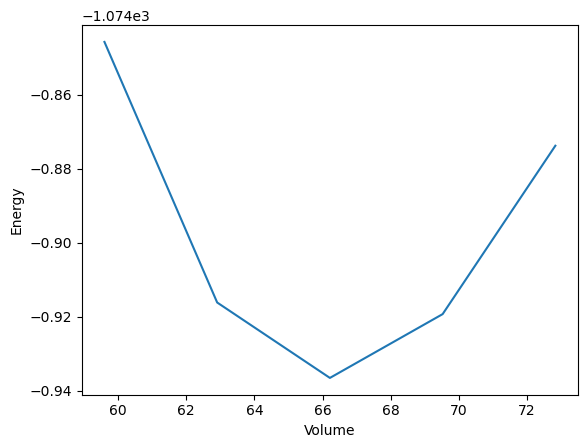

In [11]:
wg.run()

## Load Workflow with jobflow

In [12]:
from python_workflow_definition.jobflow import load_workflow_json

In [13]:
from jobflow.managers.local import run_locally

In [14]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [15]:
flow[0].function_kwargs["a"] = 4.05

2026-01-16 08:31:28,452 INFO Started executing jobs locally
2026-01-16 08:31:28,816 INFO Starting job - get_bulk_structure (9a8ea16b-3d54-40ab-ba1c-ed56a2f6c7a3)
2026-01-16 08:31:28,821 INFO Finished job - get_bulk_structure (9a8ea16b-3d54-40ab-ba1c-ed56a2f6c7a3)
2026-01-16 08:31:28,821 INFO Starting job - get_dict (0dbdd8f7-8a2f-4160-be09-0620e7fa3bea)
2026-01-16 08:31:28,825 INFO Finished job - get_dict (0dbdd8f7-8a2f-4160-be09-0620e7fa3bea)
2026-01-16 08:31:28,826 INFO Starting job - calculate_qe (583839c2-ffac-4ef2-8ca4-64c2a7701745)
2026-01-16 08:32:37,487 INFO Finished job - calculate_qe (583839c2-ffac-4ef2-8ca4-64c2a7701745)
2026-01-16 08:32:37,489 INFO Starting job - generate_structures (c8cf3dd8-ddfc-4f28-9d19-6da0ab99346f)
2026-01-16 08:32:37,497 INFO Finished job - generate_structures (c8cf3dd8-ddfc-4f28-9d19-6da0ab99346f)
2026-01-16 08:32:37,498 INFO Starting job - get_dict (f50678d3-6d30-4941-822d-e9e46a0d42aa)
2026-01-16 08:32:37,501 INFO Finished job - get_dict (f50678d3

{'9a8ea16b-3d54-40ab-ba1c-ed56a2f6c7a3': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

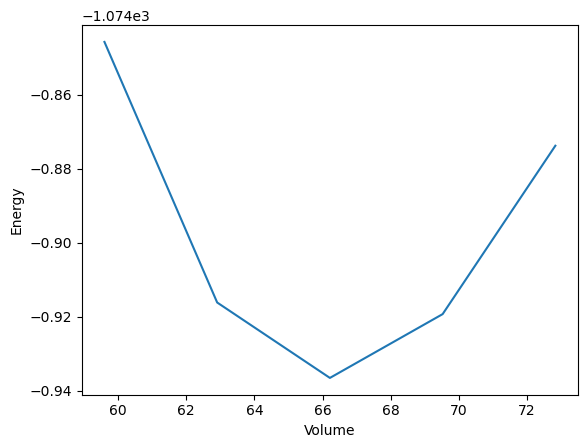

In [16]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [17]:
from python_workflow_definition.pyiron_base import load_workflow_json

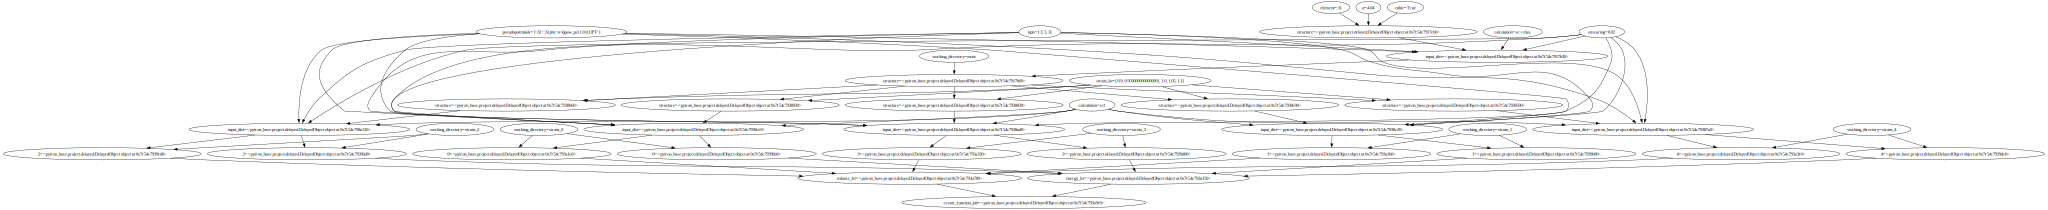

In [18]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [19]:
delayed_object_lst[0].input['a'] = 4.05

The job get_bulk_structure_2ca4aeae204ceaa28593c93054b07908 was saved and received the ID: 40
The job get_dict_1e47509b88d63a21fd421686554c8f4a was saved and received the ID: 41
The job calculate_qe_411e578f2700d09ba2df9a4c682b4582 was saved and received the ID: 42
The job generate_structures_7f140b9836b0bba16af81baf1b246241 was saved and received the ID: 43
The job get_dict_c58ae4a3f59bfb45975f3785a2ea7f39 was saved and received the ID: 44
The job calculate_qe_fe50ef8ac8518002303cd38ac9d6815a was saved and received the ID: 45
The job get_dict_15fbde13a9aabf52685fc04f66093040 was saved and received the ID: 46
The job calculate_qe_80b9c98a7807cac136aa34a89dde5b3c was saved and received the ID: 47
The job get_dict_63901158944acf473876b0bcffdfc90c was saved and received the ID: 48
The job calculate_qe_d20ea0f0eb2b5331fdae70cdb74b5b47 was saved and received the ID: 49
The job get_dict_0426b545b339ef96773c978a8d508c0b was saved and received the ID: 50
The job calculate_qe_0e46fbe7e87a5b5a8c

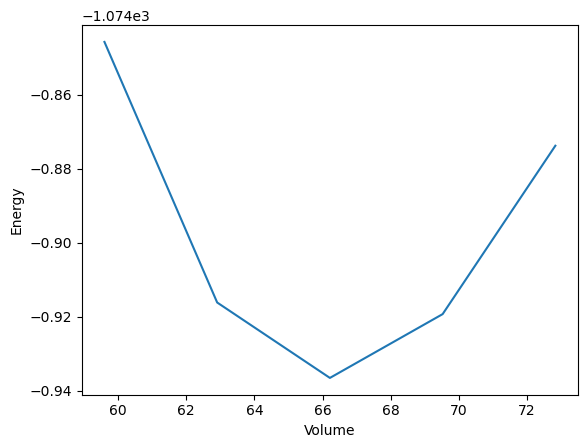

In [20]:
delayed_object_lst[-1].pull()

## Load Workflow with pyiron_workflow

In [21]:
from python_workflow_definition.pyiron_workflow import load_workflow_json

In [22]:
wf = load_workflow_json(file_name=workflow_json_filename)

In [23]:
wf.get_bulk_structure.inputs.a.value = 4.05

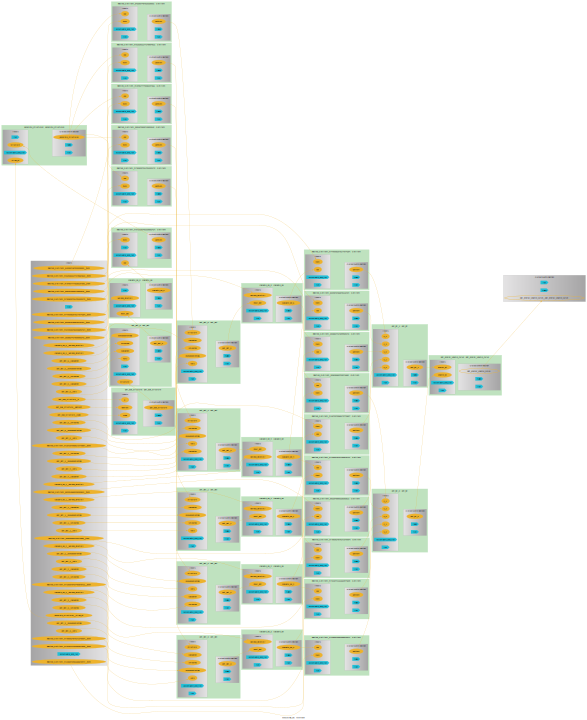

In [24]:
wf.draw(size=(10,10))

{'plot_energy_volume_curve__plot_energy_volume_curve': None}

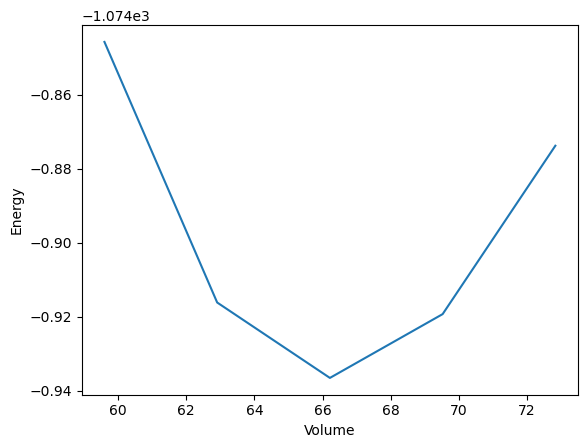

In [25]:
wf.run()